# Tutorial: Understanding MetaDynamics Parameters/ Quantitative analysis of the results

Getting tutorial files using command line 
```
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/plumed_metad_params.ipynb
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/xvg_plot.py
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/funcs.py

```

In this tutorial we will try to understand how to optimally choose MetaD parameters and estimate the error of MetaD simulations.
Prerquisites:
- It is expected that you have accomplished plumed_intro.ipynb, plumed_bias.ipynb and plumed_metad_intro.ipyn tutorials.
- This tutorial is a contunuation of the plumed_meta_intro.ipynb tutorial.
- We expect all the files generated by plumed_meta_intro.ipynb tutorial to be present in the folder.

### Step 1. Simulating a high precision MetaD run as a reference.

First we will make a long MetaD run and use mild biasing parameters to minimize the biasing effects on the profile.

In [13]:
%%bash
for i in `seq 0 4`; do
cp MDProtocols/prod.mdp MDProtocols/prod_walkers$i.mdp
echo "ld-seed=$i" >> MDProtocols/prod_walkers$i.mdp
gmx grompp -f MDProtocols/prod_walkers$i.mdp -c equil.gro -p topol.top -o prod_walkers$i.tpr -r init_solv_ions.pdb -maxwarn 2 >/dev/null 2>&1

cp MDProtocols/prod1ns.mdp MDProtocols/prod1ns_walkers$i.mdp
echo "ld-seed=$i" >> MDProtocols/prod1ns_walkers$i.mdp
gmx grompp -f MDProtocols/prod1ns_walkers$i.mdp -c equil.gro -p topol.top -o prod1ns_walkers$i.tpr -r init_solv_ions.pdb -maxwarn 2 >/dev/null 2>&1

cp MDProtocols/prod2ns.mdp MDProtocols/prod2ns_walkers$i.mdp
echo "ld-seed=$i" >> MDProtocols/prod2ns_walkers$i.mdp
gmx grompp -f MDProtocols/prod2ns_walkers$i.mdp -c equil.gro -p topol.top -o prod2ns_walkers$i.tpr -r init_solv_ions.pdb -maxwarn 2 >/dev/null 2>&1

cp MDProtocols/prod100ns.mdp MDProtocols/prod100ns_walkers$i.mdp
echo "ld-seed=$i" >> MDProtocols/prod100ns_walkers$i.mdp
gmx grompp -f MDProtocols/prod100ns_walkers$i.mdp -c equil.gro -p topol.top -o prod100ns_walkers$i.tpr -r init_solv_ions.pdb -maxwarn 2 >/dev/null 2>&1



done

In [ ]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=1 PACE=200 FILE=HILLS_t1_02_1_200_100ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
#The next line runs MD, takes a lot of time, and better should be run from a terminal, or even a Tmux terminal.
#!mpirun -np 4 mdrun_mpi -deffnm prod100ns_walkers -plumed plumed_walkers.dat -multi 4 #2> /dev/null 



In [4]:
#As a result one gets a big HILLS_t1_02_1_200_100ns.dat file with a lot of data.
!ls -lh HILLS_t1_02_1_200_100ns.dat
!wc -l HILLS_t1_02_1_200_100ns.dat
#The file should have 4*50 000 000/200 lines = 1 million
#Here a link to the file for download https://www.dropbox.com/s/n4uf241idya8vz5/HILLS_t1_02_1_200_100ns.dat?dl=0
#!wget https://www.dropbox.com/s/n4uf241idya8vz5/HILLS_t1_02_1_200_100ns.dat?dl=0

-rw-rw-r-- 1 alexsha alexsha 111M Jan 21 08:19 HILLS_t1_02_1_200_100ns.dat
1000005 HILLS_t1_02_1_200_100ns.dat


In [49]:
!mkdir -p big_data
!plumed sum_hills --hills HILLS_t1_02_1_200_100ns.dat  --outfile big_data/sumhills_t1_02_1_200_100ns.dat  --mintozero  >/dev/null

Labels found: ['phi33', 'file.free', 'der_phi33']


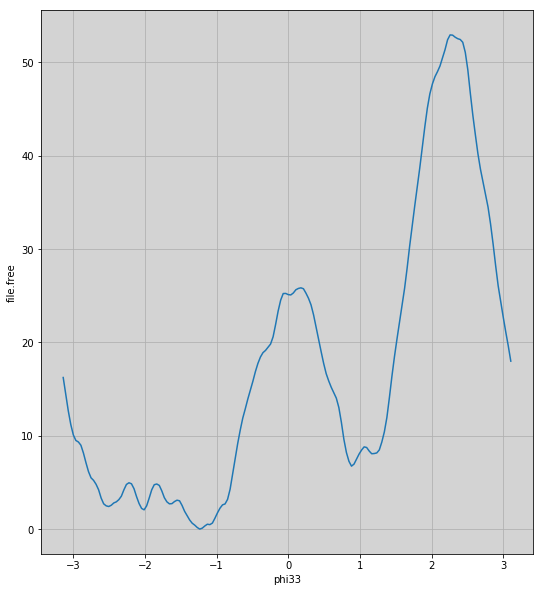

In [50]:
from funcs import plot_plumed
d=plot_plumed('big_data/sumhills_t1_02_1_200_100ns.dat',figsize=(10,10),col2plot=[1]) 

In [26]:
#We will output free energy profile every 100 000 steps
# Note from manual https://plumed.github.io/doc-v2.5/user-doc/html/sum_hills.html
# That stride outputs cumulative averages, to split in blocks use --nohistory keyword
!mkdir -p big_data
!plumed sum_hills --stride 100000 --hills HILLS_t1_02_1_200_100ns.dat --outfile big_data/sumhills_t1_02_1_200_100ns.dat --mintozero >/dev/null
!plumed sum_hills --stride 100000 --hills HILLS_t1_02_1_200_100ns.dat --outfile big_data/sumhills_t1_02_1_200_100ns_nohis.dat --mintozero --nohistory >/dev/null

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


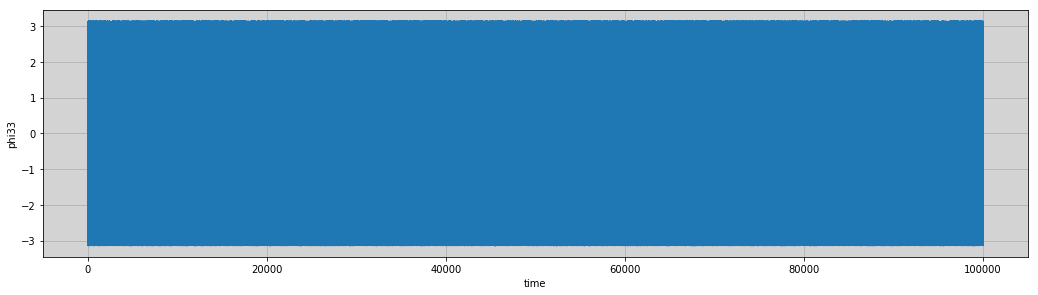

Text(0, 0.5, 'Energy, kJ/mol')

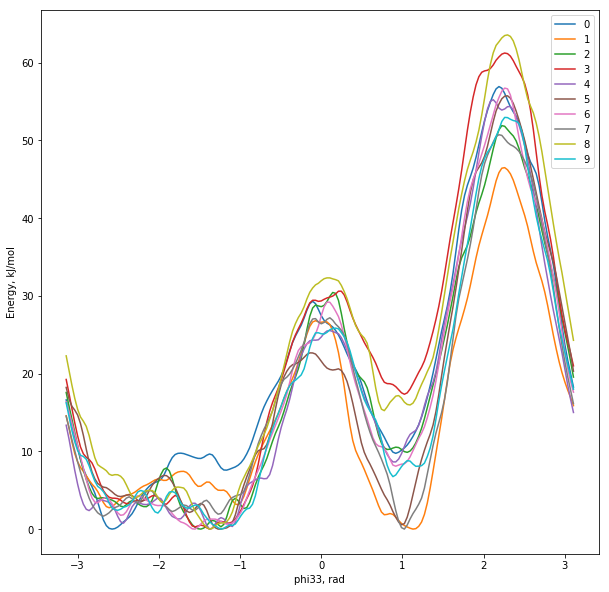

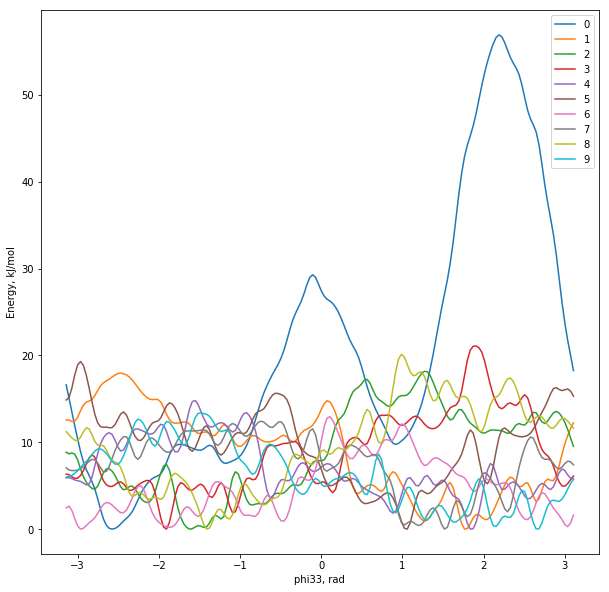

In [9]:
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Let's see the trajectory and understand sampling
d=plot_plumed('HILLS_t1_02_1_200_100ns.dat',figsize=(20,5),col2plot=[1])    

plt.figure(figsize=(10,10))
for i in range(10):
    data=plot_plumed('sumhills_t1_02_1_200_100ns.dat%d.dat'%i,plot=False,silent=True)
    plt.plot(data[:,0],data[:,1],label="%d"%i)
plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')

plt.figure(figsize=(10,10))
for i in range(10):
    data=plot_plumed('sumhills_t1_02_1_200_100ns_nohis.dat%d.dat'%i,plot=False,silent=True)
    plt.plot(data[:,0],data[:,1],label="%d"%i)
plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')


Let's understand the results:
- As explained in previous tutorial the MetaD potential fluctuates around the Free energy surface with an error of $\epsilon^2 \propto \frac{W/\tau}{D}$ 
- This is what we see on plots above.
- In theory the MetaD potential should be averaged out over the region where the dynamics has become diffusive to get the FES 
$$\bar F(\vec s) = - \frac{1}{t_\text{sim} - t_\text{diff}}
                          \int^{t_\text{sim}}_{t_\text{diff}} \!\!\!\!\!V_\text{bias}(\vec s, t)\, dt + C$$

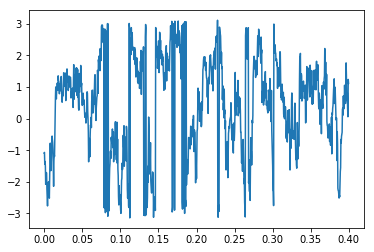

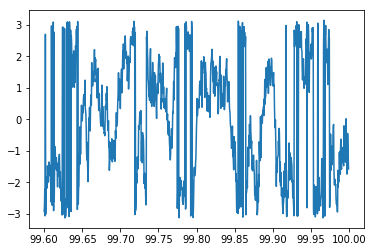

In [21]:
#Let's explore the diffusion
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#Beginning of trj
r=d[0:4000:4,1]
t=np.arange(0,100,0.0004)[0:1000]
plt.plot(t,r)

#End of trj
plt.figure()
r=d[-4000:-1:4,1]
t=np.arange(0,100,0.0004)[-1000:]
plt.plot(t,r)

- Clearly 1 ns and even 0.1 is enough to diffuse through all values of the angle.
- Let's do classical convergence analysis with 0.1 ns step.

In [32]:
#We will output free energy profile every 0.1 ns
# That stride outputs cumulative averages, to split in blocks use --nohistory keyword
!mkdir -p big_data
!plumed sum_hills --stride 1000 --hills HILLS_t1_02_1_200_100ns.dat --outfile big_data/sumhills_t1_02_1_200_100ns.dat >/dev/null

Text(0, 0.5, 'Energy, kJ/mol')

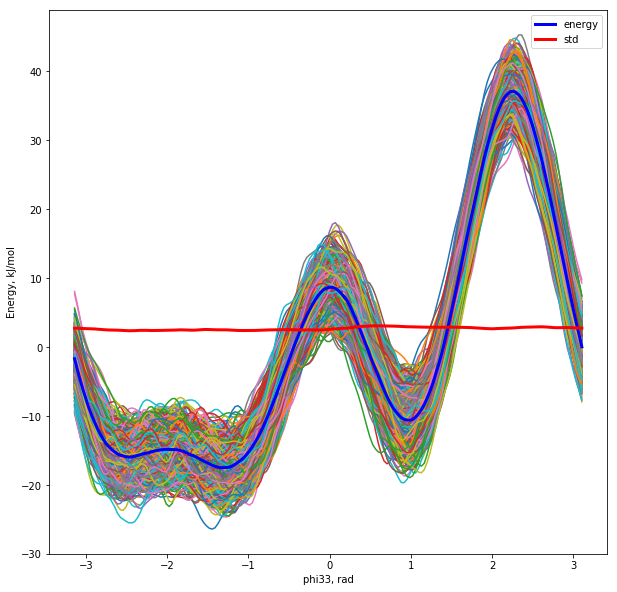

In [31]:
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
sum_df=pd.DataFrame()

plt.figure(figsize=(10,10))
for i in range(1000):
    data=plot_plumed('big_data/sumhills_t1_02_1_200_100ns.dat%d.dat'%i,plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
    plt.plot(df['angle'],df['energy'],label='_nolegend_')
df_avr=sum_df.groupby('angle', as_index=False).energy.mean()
std=sum_df.groupby('angle').energy.std()
plt.plot(df_avr['angle'],df_avr['energy'],'b-',linewidth=3)
plt.plot(std,'r-',linewidth=3,label='std')
plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')


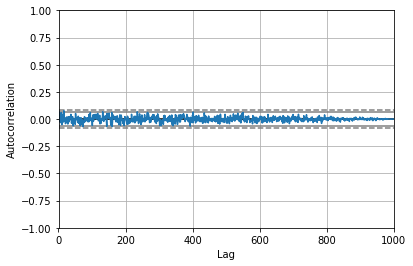

In [32]:
#Let's estimate correlations.
#sum_df.iloc[0]
data=sum_df.loc[sum_df['angle']<-3.141592,'energy']
#.autocorr()
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data)
#Correlations are below 99% interval, as seen on the plot.

Text(0, 0.5, 'Energy, kJ/mol')

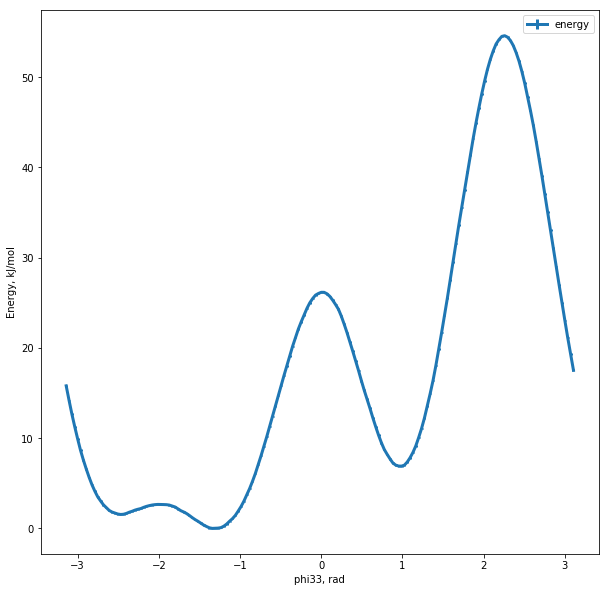

In [33]:
#We can draw and save Free energy with error estimates.
#we'll devide std by sqrt(N)
df_avr['energy']=df_avr['energy']-df_avr['energy'].min()
plt.figure(figsize=(10,10))
plt.errorbar(df_avr['angle'],df_avr['energy'],yerr=std.values/(1000**0.5),linewidth=3)
plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')

In [34]:
### We will save the reference profile
df_avr.to_csv('reference_FEP_phi33.cvs')

### Quantitative assessment
### Do convergence and quality analisys for different parameters
- Let's compress all analysis in one block first and try to compare simulations with different parameters.
- We'll also bias only one torsion for now.
- Note: simulations take time, the resulting plots produced by them can be seen below.

Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


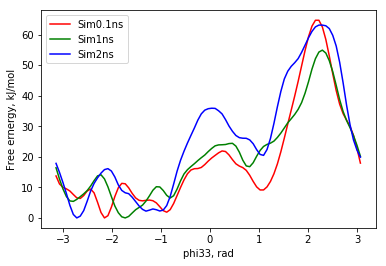

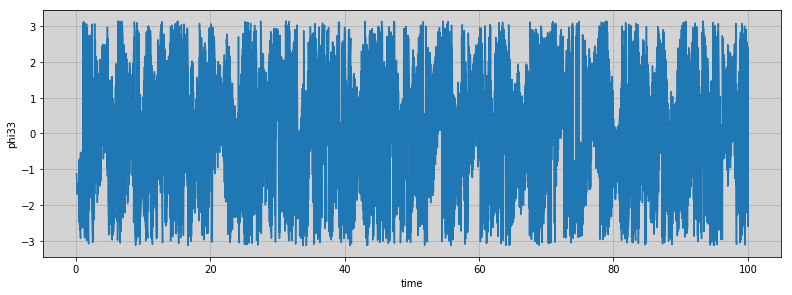

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


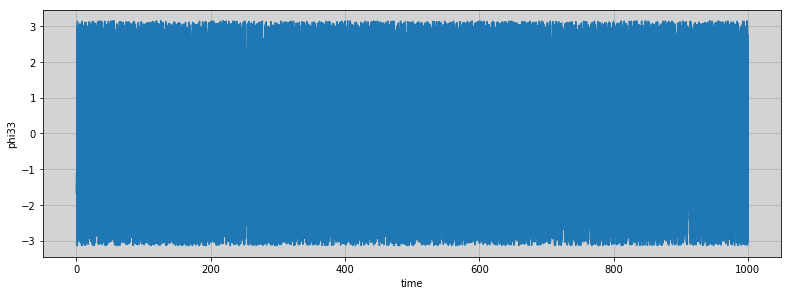

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


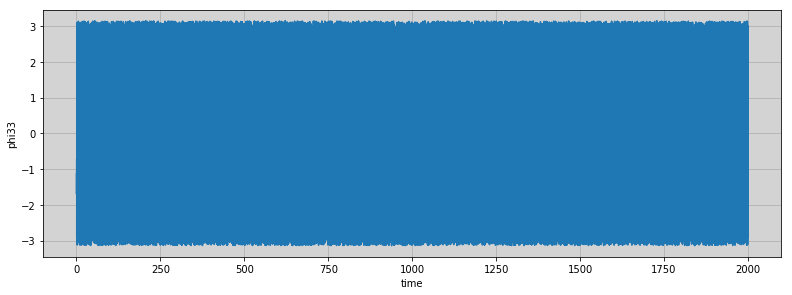

In [17]:
#Compare 1ns vs 0.1 ns run
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=5 PACE=50 FILE=HILLS_t1_02_5_50_01ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_01ns.dat --outfile sumhills_t1_02_5_50_01ns.dat --mintozero >/dev/null

!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=5 PACE=50 FILE=HILLS_t1_02_5_50_1ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod1ns_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_1ns.dat --outfile sumhills_t1_02_5_50_1ns.dat --mintozero >/dev/null

!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=5 PACE=50 FILE=HILLS_t1_02_5_50_2ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod2ns_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_2ns.dat --outfile sumhills_t1_02_5_50_2ns.dat --mintozero >/dev/null
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
data1=plot_plumed('sumhills_t1_02_5_50_01ns.dat',figsize=(5,5),plot=False)
data2=plot_plumed('sumhills_t1_02_5_50_1ns.dat',figsize=(5,5),plot=False)
data3=plot_plumed('sumhills_t1_02_5_50_2ns.dat',figsize=(5,5),plot=False)
plt.plot(data1[:,0],data1[:,1],'r-',label='Sim0.1ns')
plt.plot(data2[:,0],data2[:,1],'g-',label='Sim1ns')
plt.plot(data3[:,0],data3[:,1],'b-',label='Sim2ns')
plt.xlabel('phi33, rad')
plt.ylabel('Free ernergy, kJ/mol')
plt.legend()
d=plot_plumed('HILLS_t1_02_5_50_01ns.dat',figsize=(15,5),col2plot=[1])    
d=plot_plumed('HILLS_t1_02_5_50_1ns.dat',figsize=(15,5),col2plot=[1])    
d=plot_plumed('HILLS_t1_02_5_50_2ns.dat',figsize=(15,5),col2plot=[1])    

Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


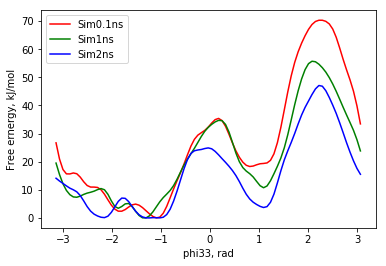

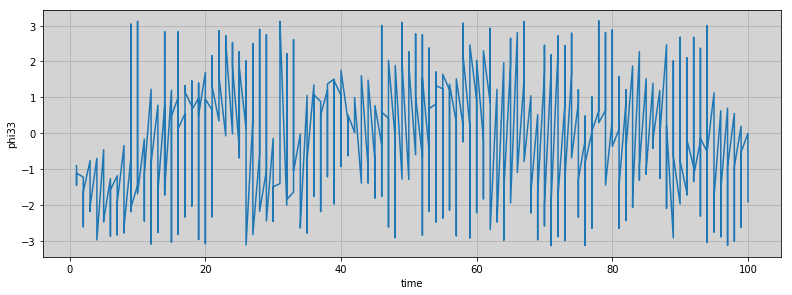

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


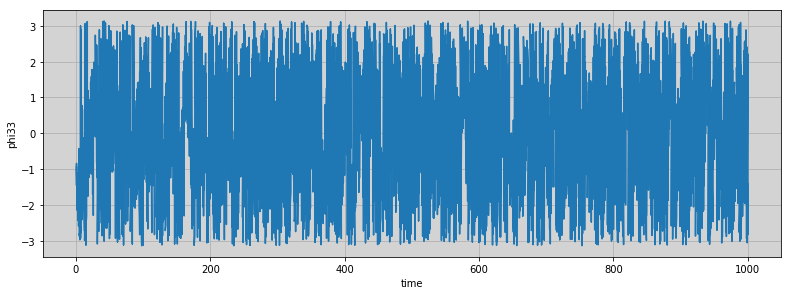

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


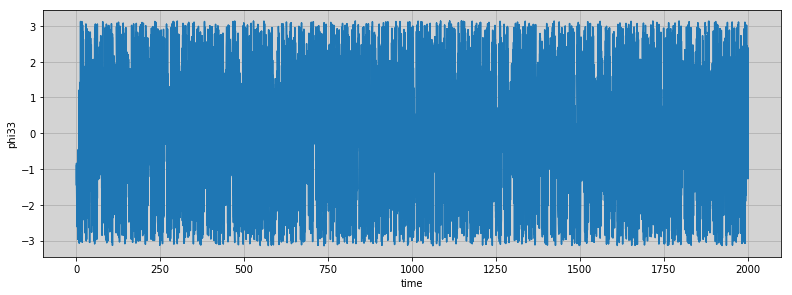

In [2]:
#Compare 1ns vs 0.1 ns run
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=5 PACE=500 FILE=HILLS_t1_02_5_50_01ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_01ns.dat --outfile sumhills_t1_02_5_50_01ns.dat --mintozero >/dev/null


!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=5 PACE=500 FILE=HILLS_t1_02_5_50_1ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod1ns_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_1ns.dat --outfile sumhills_t1_02_5_50_1ns.dat --mintozero >/dev/null

!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=5 PACE=500 FILE=HILLS_t1_02_5_50_2ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod2ns_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_2ns.dat --outfile sumhills_t1_02_5_50_2ns.dat --mintozero >/dev/null
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
data1=plot_plumed('sumhills_t1_02_5_50_01ns.dat',figsize=(5,5),plot=False)
data2=plot_plumed('sumhills_t1_02_5_50_1ns.dat',figsize=(5,5),plot=False)
data3=plot_plumed('sumhills_t1_02_5_50_2ns.dat',figsize=(5,5),plot=False)
plt.plot(data1[:,0],data1[:,1],'r-',label='Sim0.1ns')
plt.plot(data2[:,0],data2[:,1],'g-',label='Sim1ns')
plt.plot(data3[:,0],data3[:,1],'b-',label='Sim2ns')
plt.xlabel('phi33, rad')
plt.ylabel('Free ernergy, kJ/mol')
plt.legend()
d=plot_plumed('HILLS_t1_02_5_50_01ns.dat',figsize=(15,5),col2plot=[1])    
d=plot_plumed('HILLS_t1_02_5_50_1ns.dat',figsize=(15,5),col2plot=[1])    
d=plot_plumed('HILLS_t1_02_5_50_2ns.dat',figsize=(15,5),col2plot=[1])    

Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


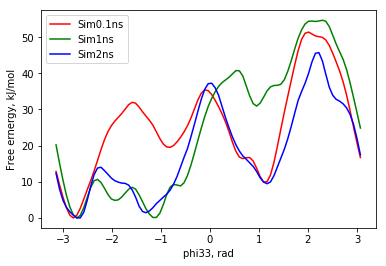

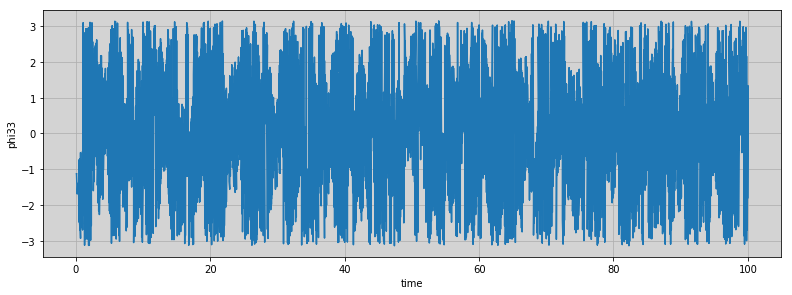

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


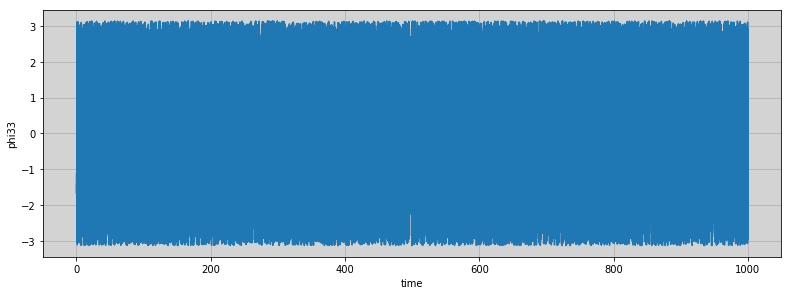

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


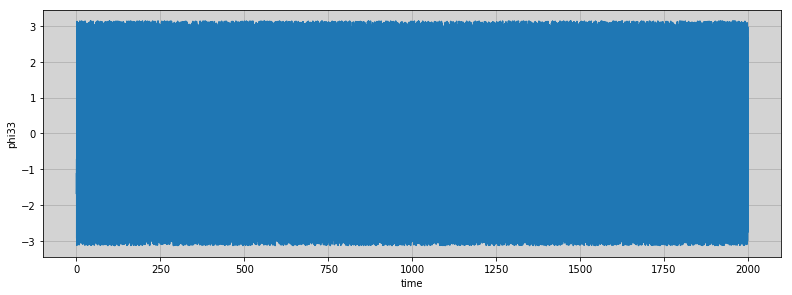

In [3]:
#Compare 1ns vs 0.1 ns run
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=5 PACE=50 FILE=HILLS_t1_02_5_50_01ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_01ns.dat --outfile sumhills_t1_02_5_50_01ns.dat --mintozero >/dev/null


!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=5 PACE=50 FILE=HILLS_t1_02_5_50_1ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod1ns_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_1ns.dat --outfile sumhills_t1_02_5_50_1ns.dat --mintozero >/dev/null

!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=5 PACE=50 FILE=HILLS_t1_02_5_50_2ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod2ns_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_2ns.dat --outfile sumhills_t1_02_5_50_2ns.dat --mintozero >/dev/null
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
data1=plot_plumed('sumhills_t1_02_5_50_01ns.dat',figsize=(5,5),plot=False)
data2=plot_plumed('sumhills_t1_02_5_50_1ns.dat',figsize=(5,5),plot=False)
data3=plot_plumed('sumhills_t1_02_5_50_2ns.dat',figsize=(5,5),plot=False)
plt.plot(data1[:,0],data1[:,1],'r-',label='Sim0.1ns')
plt.plot(data2[:,0],data2[:,1],'g-',label='Sim1ns')
plt.plot(data3[:,0],data3[:,1],'b-',label='Sim2ns')
plt.xlabel('phi33, rad')
plt.ylabel('Free ernergy, kJ/mol')
plt.legend()
d=plot_plumed('HILLS_t1_02_5_50_01ns.dat',figsize=(15,5),col2plot=[1])    
d=plot_plumed('HILLS_t1_02_5_50_1ns.dat',figsize=(15,5),col2plot=[1])    
d=plot_plumed('HILLS_t1_02_5_50_2ns.dat',figsize=(15,5),col2plot=[1])    

Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


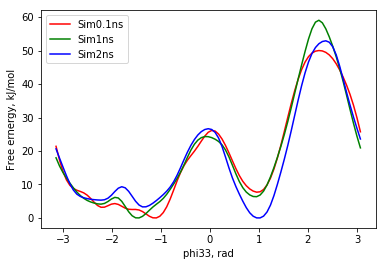

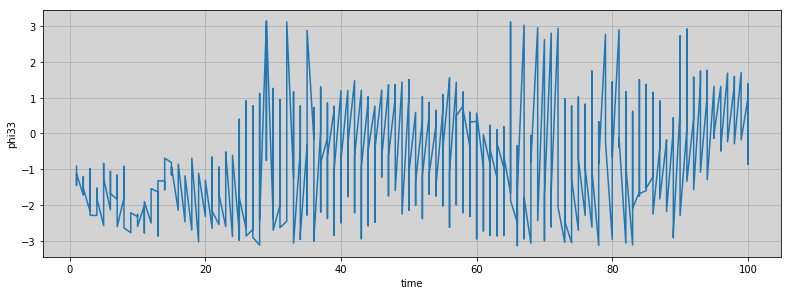

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


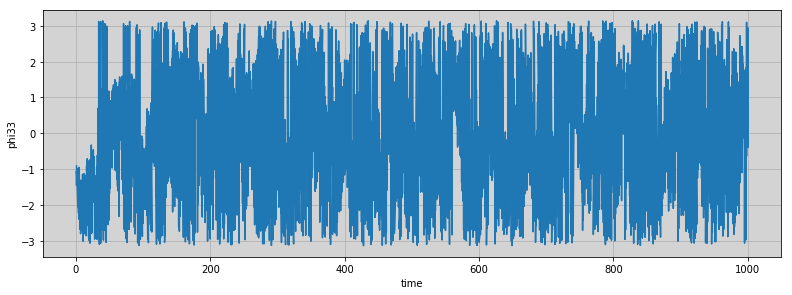

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


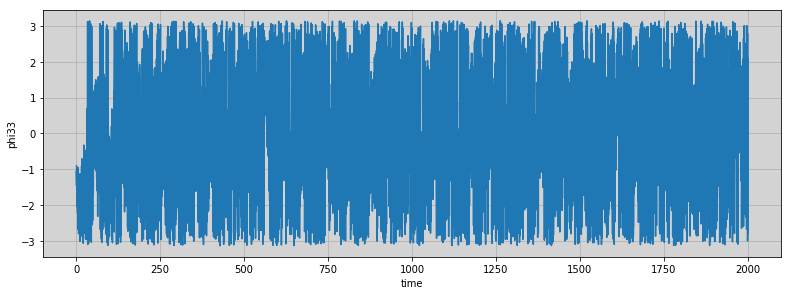

In [4]:
#Compare 1ns vs 0.1 ns run
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=1 PACE=500 FILE=HILLS_t1_02_5_50_01ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_01ns.dat --outfile sumhills_t1_02_5_50_01ns.dat --mintozero >/dev/null


!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=1 PACE=500 FILE=HILLS_t1_02_5_50_1ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod1ns_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_1ns.dat --outfile sumhills_t1_02_5_50_1ns.dat --mintozero >/dev/null

!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=1 PACE=500 FILE=HILLS_t1_02_5_50_2ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod2ns_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_2ns.dat --outfile sumhills_t1_02_5_50_2ns.dat --mintozero >/dev/null
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
data1=plot_plumed('sumhills_t1_02_5_50_01ns.dat',figsize=(5,5),plot=False)
data2=plot_plumed('sumhills_t1_02_5_50_1ns.dat',figsize=(5,5),plot=False)
data3=plot_plumed('sumhills_t1_02_5_50_2ns.dat',figsize=(5,5),plot=False)
plt.plot(data1[:,0],data1[:,1],'r-',label='Sim0.1ns')
plt.plot(data2[:,0],data2[:,1],'g-',label='Sim1ns')
plt.plot(data3[:,0],data3[:,1],'b-',label='Sim2ns')
plt.xlabel('phi33, rad')
plt.ylabel('Free ernergy, kJ/mol')
plt.legend()
d=plot_plumed('HILLS_t1_02_5_50_01ns.dat',figsize=(15,5),col2plot=[1])    
d=plot_plumed('HILLS_t1_02_5_50_1ns.dat',figsize=(15,5),col2plot=[1])    
d=plot_plumed('HILLS_t1_02_5_50_2ns.dat',figsize=(15,5),col2plot=[1])    

Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['phi33', 'file.free', 'der_phi33']
Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


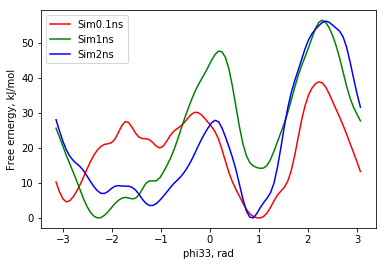

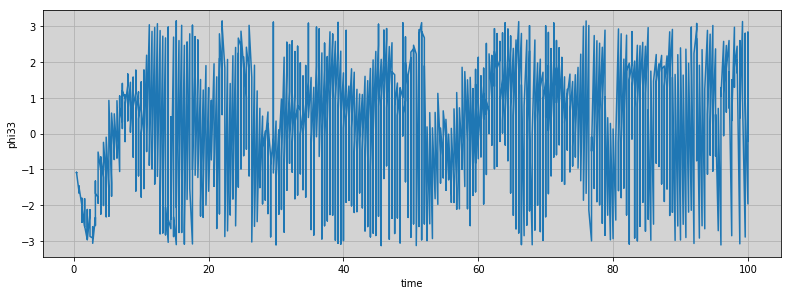

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


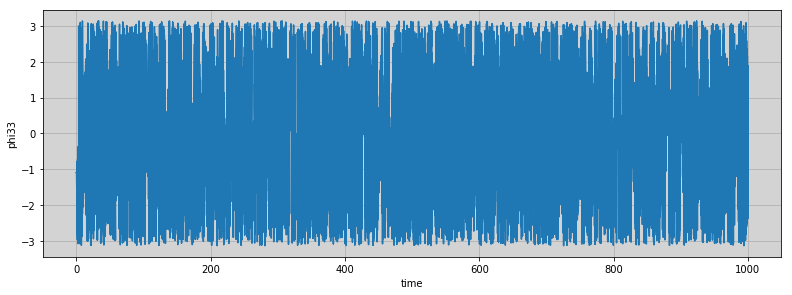

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


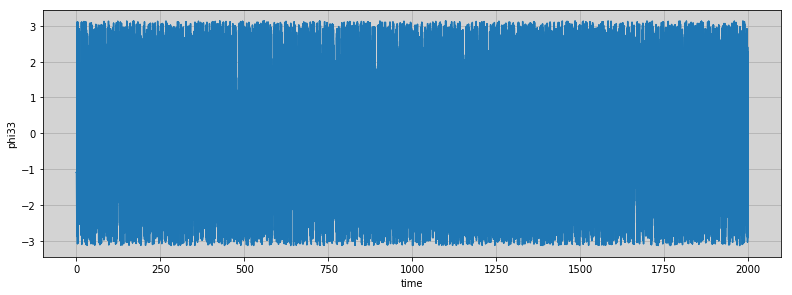

In [5]:
#Compare 1ns vs 0.1 ns run
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=5 PACE=200 FILE=HILLS_t1_02_5_50_01ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_01ns.dat --outfile sumhills_t1_02_5_50_01ns.dat --mintozero >/dev/null


!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=5 PACE=200 FILE=HILLS_t1_02_5_50_1ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod1ns_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_1ns.dat --outfile sumhills_t1_02_5_50_1ns.dat --mintozero >/dev/null

!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 SIGMA=0.2 HEIGHT=5 PACE=200 FILE=HILLS_t1_02_5_50_2ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
!mpirun -np 4 mdrun_mpi -deffnm prod2ns_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 
!plumed sum_hills --hills HILLS_t1_02_5_50_2ns.dat --outfile sumhills_t1_02_5_50_2ns.dat --mintozero >/dev/null
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
data1=plot_plumed('sumhills_t1_02_5_50_01ns.dat',figsize=(5,5),plot=False)
data2=plot_plumed('sumhills_t1_02_5_50_1ns.dat',figsize=(5,5),plot=False)
data3=plot_plumed('sumhills_t1_02_5_50_2ns.dat',figsize=(5,5),plot=False)
plt.plot(data1[:,0],data1[:,1],'r-',label='Sim0.1ns')
plt.plot(data2[:,0],data2[:,1],'g-',label='Sim1ns')
plt.plot(data3[:,0],data3[:,1],'b-',label='Sim2ns')
plt.xlabel('phi33, rad')
plt.ylabel('Free ernergy, kJ/mol')
plt.legend()
d=plot_plumed('HILLS_t1_02_5_50_01ns.dat',figsize=(15,5),col2plot=[1])    
d=plot_plumed('HILLS_t1_02_5_50_1ns.dat',figsize=(15,5),col2plot=[1])    
d=plot_plumed('HILLS_t1_02_5_50_2ns.dat',figsize=(15,5),col2plot=[1])    

From plot above, we see that the behavior of the CV is diffusive - which is good.
However, we can not clam that at 2 ns, the free energy profile has converged.

In [83]:
## Other commands

In [27]:
# Auxilary
# Clear files
!rm \#*
!rm bck*
!rm sumhills*

rm: cannot remove '#*': No such file or directory
rm: cannot remove 'bck*': No such file or directory


In [6]:
from importlib import reload
import funcs
reload(funcs)

<module 'funcs' from '/home/alexsha/projects/MolModEdu/PLUMED/funcs.py'>

## A note on choosing CVs

Another instructive example can be found in Ref 26. Here, the authors wanted to study the penetra- tion of tetramethylammonium (TMA) into the acetyl- cholinesterase (AChE) gorge. In a first trial, only the distance between the center of mass of TMA and the active site of AChE was used as CV. This metadynam- ics run was not successful, as the system sometimes showed a diffusive behavior in the CV, whereas at other times, it got stuck at a particular point. This hysteretic behavior is the typical sign that a slow mo- tion of the system is not included in the CVs. As a result, the system remains stuck at a certain posi- tion until the rare event involving the hidden variable eventually takes place

By inspecting Figure trieste-4-metad-psi-phi-fig, we notice that something different happened compared to the previous exercise. At first the behavior of ψ looks diffusive in the entire CV space. However, around t=1 ns, ψ seems trapped in a region of the CV space in which it was previously diffusing without problems. The reason is that the non-biased CV ϕ after a while has jumped into a different local minima. Since ϕ is not directly biased, one has to wait for this (slow) degree of freedom to equilibrate before the free energy along ψ can converge.

Try to repeat the analysis done in the previous exercise, i.e. calculate the estimate of the free energy as a function of time, first step to assess the convergence of this metadynamics simulation.
